In [1]:
#!pip install pandas matplotlib tensorflow seaborn opencv-python scikit-learn xgboost

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Dataset paths

In [3]:
TRAIN_PATH = "data/train"
TEST_PATH = "data/test"
TRAIN_LABEL_PATH = TRAIN_PATH + "/labels"
TEST_LABEL_PATH = TEST_PATH + "/labels"
label_mapping = {0: 0, 90: 1, 180: 2, 270: 3}  # Map angles to consecutive labels for XGBoost

Create function to load images and labels

In [4]:
def load_data(path,label_path):
    """
    Load images from the dataset directories and segregating images and 
    labels, resizing images for better runtime of ML algorithms.
    """
    with open(label_path, encoding= 'utf-8') as labels:
        content = labels.read()
        
    content = content.split("\n")
    images = []
    labels = []
    for row in content:
        if row:

            file_name, label = row.split(", ")
            # While converting images to arrays (imread) use os.path.join 
            # to prepare the image path ensuring platform independence
            image = cv2.imread(os.path.join(path,file_name))
            
            image = cv2.resize(image,(200,200))
            images.append(image)
            labels.append(label_mapping[int(label)])
    return images, labels   

In [5]:
images_train, labels_train = load_data(TRAIN_PATH,TRAIN_LABEL_PATH)

In [6]:
print(len(images_train), len(labels_train))

203 203


In [7]:
images_test, labels_test = load_data(TEST_PATH,TEST_LABEL_PATH)

In [8]:
print(len(images_test), len(labels_test))

88 88


ML feature extraction from given images

In [9]:
def feature_extraction(images):
    """
    Extracting features from the input images.
    Instead of using the pixel values from the three channels separately, 
    we can generate a new matrix that has the mean value of pixels from 
    all three channels. By doing so, the number of features remains the 
    same and we also take into account the pixel values from all three 
    channels of the image.
    """
    
    final_features = []
    for image in images:

        feature_matrix = np.zeros((image.shape[0],image.shape[1]), dtype = int)

        # We have a 3D matrix of dimension (200 x 200 x 3) where 200 
        # is the height, 200 is the width and 3 is the number of channels. 
        # To get the average pixel values, we will use for loop. The new 
        # matrix will have the same height and width but only 1 channel. 
        # Now we can follow the same steps that we did in the previous 
        # section. We append the pixel values one after the other to get a
        # 1D array
        
        for j in range(0,image.shape[0]):
            for k in range(0,image.shape[1]):
                feature_matrix[j][k] = \
                int((int(image[j,k,0]) + int(image[j,k,1]) + int(image[j,k,2]))/3)
        features = np.reshape(feature_matrix, (image.shape[0]*image.shape[1]))
        final_features.append(features)
    return final_features

In [10]:
final_train_features = feature_extraction(images_train)

In [11]:
final_test_features = feature_extraction(images_test)

In [12]:
def train_model(features, labels, param,model):
    """
    Function to train ML models with Cross validation and 
    hyper parameter tuning using GridSearchCV
    """
    grid_search  = GridSearchCV(model, param, scoring='accuracy', cv=5, verbose = 3)
    grid_search.fit(features, labels)
    
    return grid_search.best_estimator_, grid_search.best_params_, \
           grid_search.best_score_
    

KNN 

In [13]:
model = KNeighborsClassifier()

In [14]:
param_knn = {"n_neighbors":[5,10,20,30]}

Training KNN model

In [15]:
model, best_params, best_score = train_model(final_train_features,
                                             labels_train, 
                                             param_knn, 
                                             model)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....................n_neighbors=5;, score=0.707 total time=   0.1s
[CV 2/5] END .....................n_neighbors=5;, score=0.854 total time=   0.0s
[CV 3/5] END .....................n_neighbors=5;, score=0.732 total time=   0.0s
[CV 4/5] END .....................n_neighbors=5;, score=0.775 total time=   0.1s
[CV 5/5] END .....................n_neighbors=5;, score=0.775 total time=   0.0s
[CV 1/5] END ....................n_neighbors=10;, score=0.805 total time=   0.0s
[CV 2/5] END ....................n_neighbors=10;, score=0.829 total time=   0.0s
[CV 3/5] END ....................n_neighbors=10;, score=0.780 total time=   0.1s
[CV 4/5] END ....................n_neighbors=10;, score=0.825 total time=   0.0s
[CV 5/5] END ....................n_neighbors=10;, score=0.850 total time=   0.0s
[CV 1/5] END ....................n_neighbors=20;, score=0.878 total time=   0.0s
[CV 2/5] END ....................n_neighbors=20;,

In [16]:
print('best score', best_score)

best score 0.8473170731707317


Prediction for train data using `Trained KNN` model

In [17]:
labels_train_pred = model.predict(final_train_features)

In [18]:
print(classification_report(labels_train,labels_train_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        55
           1       0.84      0.92      0.88        51
           2       0.92      0.87      0.89        52
           3       0.90      0.80      0.85        45

    accuracy                           0.89       203
   macro avg       0.89      0.88      0.88       203
weighted avg       0.89      0.89      0.89       203



Prediction for test data using `Trained KNN` model

In [19]:
labels_test_pred = model.predict(final_test_features)

In [20]:
print(classification_report(labels_test,labels_test_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        21
           1       0.80      0.73      0.76        22
           2       0.82      0.74      0.78        19
           3       0.83      0.77      0.80        26

    accuracy                           0.81        88
   macro avg       0.81      0.81      0.80        88
weighted avg       0.81      0.81      0.80        88



XGBoost

In [21]:
param_xgboost = {
    'n_estimators': [200],  # Number of boosting rounds
    'max_depth': [10],  # Maximum depth of each tree
    'learning_rate': [0.05]} #these parameters are chosen after doing hyperparameter tuning

In [22]:
model = XGBClassifier()

Training XGBoost model

In [23]:
model, best_params, best_score = train_model(final_train_features,\
                                labels_train, param_xgboost, model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.05, max_depth=10, n_estimators=200;, score=0.829 total time=  50.3s
[CV 2/5] END learning_rate=0.05, max_depth=10, n_estimators=200;, score=0.878 total time=  58.4s
[CV 3/5] END learning_rate=0.05, max_depth=10, n_estimators=200;, score=0.756 total time= 1.1min
[CV 4/5] END learning_rate=0.05, max_depth=10, n_estimators=200;, score=0.825 total time= 1.2min
[CV 5/5] END learning_rate=0.05, max_depth=10, n_estimators=200;, score=0.825 total time= 1.1min


In [24]:
print('best score', best_score)

best score 0.8226829268292682


In [25]:
best_params

{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200}

In [26]:
labels_train_pred = model.predict(final_train_features)

In [27]:
print(classification_report(labels_train,labels_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        52
           3       1.00      1.00      1.00        45

    accuracy                           1.00       203
   macro avg       1.00      1.00      1.00       203
weighted avg       1.00      1.00      1.00       203



In [28]:
labels_test_pred = model.predict(final_test_features)

In [29]:
print(classification_report(labels_test,labels_test_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        21
           1       0.81      0.77      0.79        22
           2       0.94      0.84      0.89        19
           3       0.88      0.85      0.86        26

    accuracy                           0.86        88
   macro avg       0.87      0.87      0.86        88
weighted avg       0.87      0.86      0.86        88



Random Forest with Hyper parameter tuning

In [30]:
param_rf = {'n_estimators': [300],  # Number of boosting rounds
    'max_depth': [9]}  # Maximum depth of each tree

In [31]:
model =RandomForestClassifier()

Training Random Forest

In [32]:
model, best_params, best_score = train_model(final_train_features,labels_train, param_rf, model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END .....max_depth=9, n_estimators=300;, score=0.878 total time=   3.4s
[CV 2/5] END .....max_depth=9, n_estimators=300;, score=0.927 total time=   3.1s
[CV 3/5] END .....max_depth=9, n_estimators=300;, score=0.829 total time=   2.9s
[CV 4/5] END .....max_depth=9, n_estimators=300;, score=0.875 total time=   3.1s
[CV 5/5] END .....max_depth=9, n_estimators=300;, score=0.875 total time=   2.9s


In [33]:
labels_train_pred = model.predict(final_train_features)

In [34]:
print(classification_report(labels_train,labels_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        52
           3       1.00      1.00      1.00        45

    accuracy                           1.00       203
   macro avg       1.00      1.00      1.00       203
weighted avg       1.00      1.00      1.00       203



In [35]:
labels_test_pred = model.predict(final_test_features)

In [36]:
print(classification_report(labels_test,labels_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89        21
           1       0.94      0.73      0.82        22
           2       0.89      0.89      0.89        19
           3       0.86      0.92      0.89        26

    accuracy                           0.88        88
   macro avg       0.88      0.87      0.87        88
weighted avg       0.88      0.88      0.87        88



Visualising the prediction for Random Forest

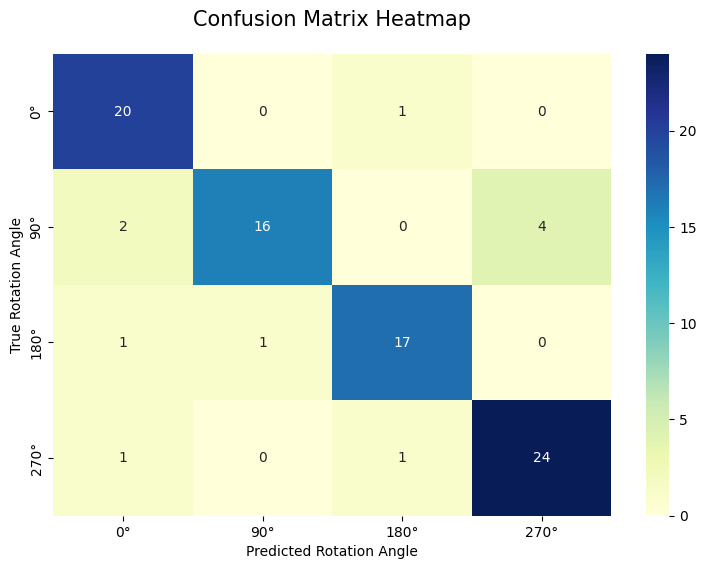

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a confusion matrix
cm = confusion_matrix(labels_test, labels_test_pred)
rotation_angles = ['0°', '90°', '180°', '270°']  # Assuming your classes are these rotation angles

# Create a heatmap from the confusion matrix
plt.figure(figsize=(9,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=rotation_angles, yticklabels=rotation_angles)

# Add labels to the plot
plt.title('Confusion Matrix Heatmap', fontsize=15, pad = 20)
plt.xlabel('Predicted Rotation Angle', fontsize=10)
plt.ylabel('True Rotation Angle', fontsize=10)

# Show the color bar
plt.show()

In [38]:
#Reverse mapping to original labels
key = []
for i in labels_test_pred:
    key.append(list(label_mapping.keys())[list(label_mapping.values())\
                                          .index(i)])

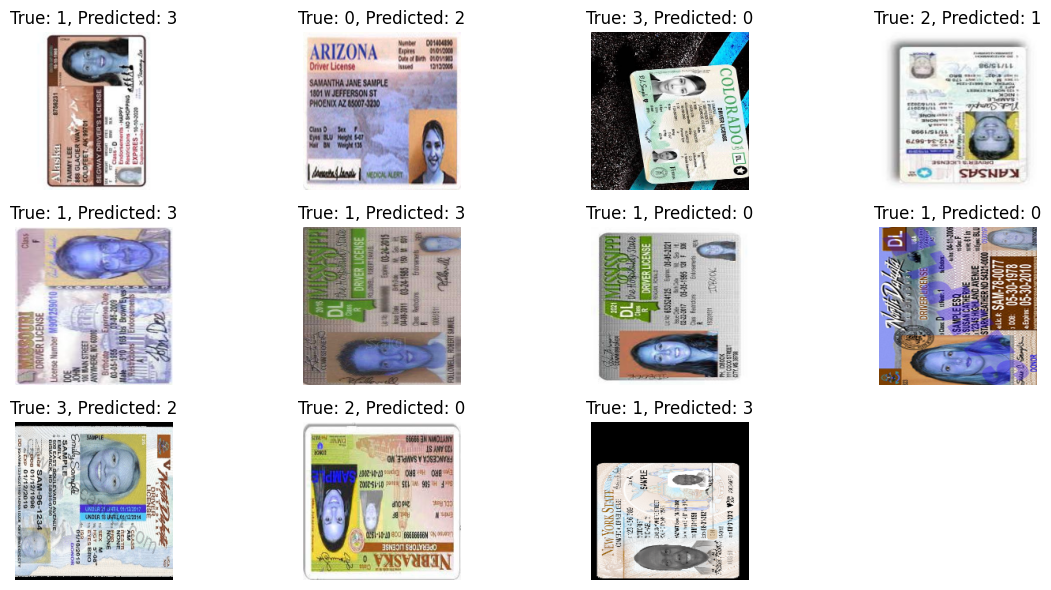

In [39]:
# Investigate misclassified samples:
misclassified_indices = np.where(labels_test_pred != labels_test)[0]
misclassified_images = [images_test[i] for i in misclassified_indices]
misclassified_true_labels = [labels_test[i] for i in misclassified_indices]
misclassified_predicted_labels = \
[labels_test_pred[i] for i in misclassified_indices]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, image in enumerate(misclassified_images):
    plt.subplot(3, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'True: {misclassified_true_labels[i]}, Predicted: {misclassified_predicted_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [40]:
from joblib import dump

# Save the model
dump(model, 'model.joblib') 

['model.joblib']

Alternate solution using CNN

In [41]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping


2023-05-30 22:29:34.662747: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model Archietecture- 3 Conv2D layer and 3 Maxpooling layer and finally 2 dense layers

In [42]:
model = Sequential() # we define sequential function for building sequential CNN architecture.
        
model.add(Conv2D(input_shape=(200,200,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten(name='flatten'))

model.add(Dense(64,activation = "relu"))
model.add(Dense(4, activation = "softmax"))


In [43]:
#Since the labels are in one column hence used loss = 'sparse_categorical_crossentropy'
model.compile(optimizer="adam", loss = "sparse_categorical_crossentropy",\
              metrics ="accuracy")

In [44]:
# Following is used to stop the training process if the model's performance
# on validation set does not improve after a given number of epochs. 
# Here it is 5
earlyStopping = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, 
                            patience=5, restore_best_weights=True)

Converting input list to numpy arrays to use in CNN

In [45]:
images_train, labels_train, images_test, labels_test \
= np.array(images_train), np.array(labels_train), np.array(images_test),np.array(labels_test)
                                                    

In [46]:
history = model.fit(images_train, labels_train,
                    validation_data=(images_test,labels_test), 
                                     batch_size = 32,epochs = 20, 
                                    callbacks= [earlyStopping])

Epoch 1/20
7/7 [==============================] - 13s 2s/step - loss: 990.7183 - accuracy: 0.2365 - val_loss: 28.1848 - val_accuracy: 0.2159
Epoch 2/20
7/7 [==============================] - 12s 2s/step - loss: 7.6045 - accuracy: 0.3251 - val_loss: 1.3128 - val_accuracy: 0.3977
Epoch 3/20
7/7 [==============================] - 13s 2s/step - loss: 1.1402 - accuracy: 0.5271 - val_loss: 1.3408 - val_accuracy: 0.5568
Epoch 4/20
7/7 [==============================] - 13s 2s/step - loss: 0.7573 - accuracy: 0.7044 - val_loss: 0.9498 - val_accuracy: 0.7045
Epoch 5/20
7/7 [==============================] - 15s 2s/step - loss: 0.7281 - accuracy: 0.7980 - val_loss: 0.8667 - val_accuracy: 0.7500
Epoch 6/20
7/7 [==============================] - 15s 2s/step - loss: 0.4755 - accuracy: 0.8571 - val_loss: 0.8517 - val_accuracy: 0.8182
Epoch 7/20
7/7 [==============================] - 15s 2s/step - loss: 0.1613 - accuracy: 0.9261 - val_loss: 0.7689 - val_accuracy: 0.8864
Epoch 8/20
7/7 [===============

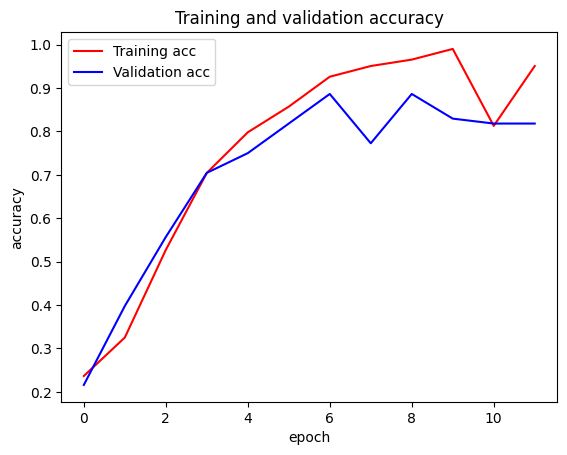

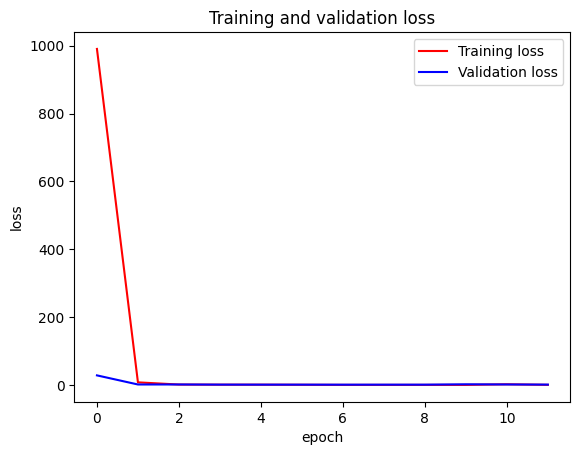

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend();

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show();

In [48]:
pred_test_labels = model.predict(images_test)# gives probability of 4 possible rotation angles
pred_test_labels = np.argmax(pred_test_labels, axis = 1)

3/3 [==============================] - 2s 514ms/step


In [49]:
print(classification_report(labels_test, pred_test_labels))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85        21
           1       0.86      0.86      0.86        22
           2       0.90      0.95      0.92        19
           3       0.89      0.92      0.91        26

    accuracy                           0.89        88
   macro avg       0.89      0.89      0.89        88
weighted avg       0.89      0.89      0.89        88



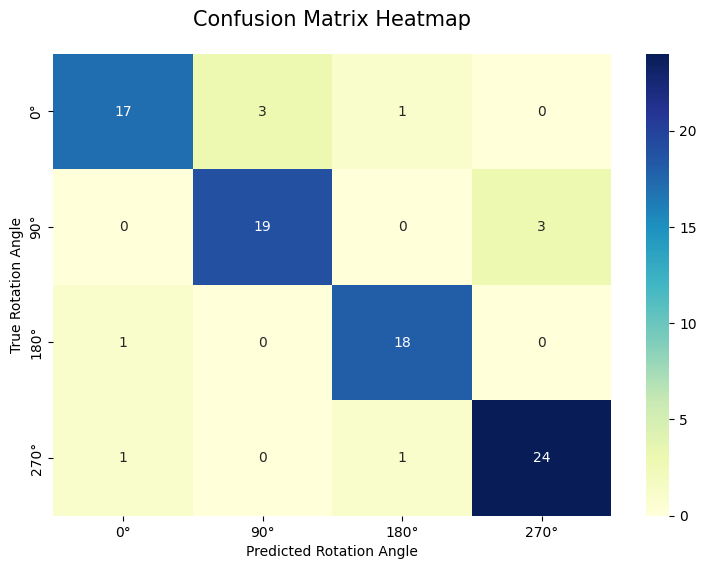

In [50]:
# Create a confusion matrix
cm = confusion_matrix(labels_test, pred_test_labels)
rotation_angles = ['0°', '90°', '180°', '270°']  # Assuming your classes are these rotation angles

# Create a heatmap from the confusion matrix
plt.figure(figsize=(9,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=rotation_angles, yticklabels=rotation_angles)

# Add labels to the plot
plt.title('Confusion Matrix Heatmap', fontsize=15, pad = 20)
plt.xlabel('Predicted Rotation Angle', fontsize=10)
plt.ylabel('True Rotation Angle', fontsize=10)

# Show the color bar
plt.show()

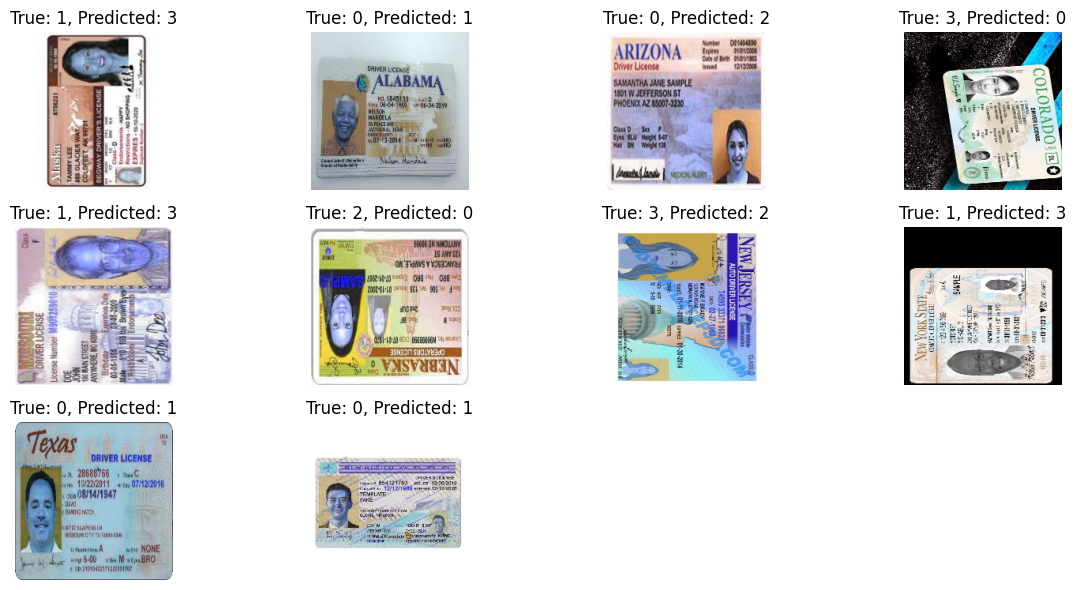

In [52]:
# Investigate misclassified samples:
misclassified_indices = np.where(pred_test_labels != labels_test)[0]
misclassified_images = [images_test[i] for i in misclassified_indices]
misclassified_true_labels = [labels_test[i] for i in misclassified_indices]
misclassified_predicted_labels = [pred_test_labels[i] for i in misclassified_indices]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, image in enumerate(misclassified_images):
    plt.subplot(3, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'True: {misclassified_true_labels[i]}, Predicted: {misclassified_predicted_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Saving the model for future use and deployment

In [53]:
model.save("imageOrientationClassifier.h5")

In [54]:
!pip freeze > requirements.txt